# Cart Pole Dynamics and MPC Examples

In this example, I explore how to generate the state space matrices for a cart with a pole using `sympy` and apply model predictive control with various solvers to control it. In particular, I test out OSQP, Clarabel, SCS via `cvxpy`. Later on, I compare the performance to LQR using the Python `control` library.

In [1]:
from IPython.display import display
import sympy
import numpy as np
import cvxpy as cvx
from scipy import sparse
import matplotlib.pyplot as plt
from sympy import UnevaluatedExpr
sympy.init_printing()

The cart pole example is a classic problem in controls, consisting of a cart with a horizontal force applied as a control input and a pole that is hinged to the cart. The goal is to balance the pole such that it remains upright. Below is a picture of the system we are trying to simulate and control.

<center>
<img src="./CartPoleGraphic.png" width="500">
</center>

We have a cart with mass $m_c$ and a pole with mass $m_p$. The pol attached to the cart on a hinge and allowed to swing freely. The pole's inertia about its center of gravity is $I_p$. The control input is a horizontal force applied to the cart, labeled as $F$. 

The states include the angle of the pole, $\theta$ and the horizontal position of the cart, $x$, along with their derivatives.

\begin{equation}
    \mathbf{x} = \begin{bmatrix} x \\ \dot{x} \\ \theta \\ \dot{\theta} \end{bmatrix}
\end{equation}


In `sympy`, we create symbols for each of these variables. We can use Latex style string to input to the symbols contructor and they will render correspondingly later. 

In [2]:
# Variables
t = sympy.symbols('t')  # time
theta = sympy.symbols('theta', cls=sympy.Function)  # angle of the pole
x = sympy.symbols('x', cls=sympy.Function)  # position of the cart
force = sympy.symbols('F')

# Parameters
mass_cart = sympy.symbols('m_c')
mass_pole = sympy.symbols('m_p')
inertia_pole = sympy.symbols('I_p')
length = sympy.symbols('l')
gravity = sympy.symbols('g')

# Define the state
state = sympy.Matrix([[x(t)], [x(t).diff(t)], [theta(t)], [theta(t).diff(t)]])

# Fake values for parameters
params  = {gravity:9.81,length:0.3, mass_cart: 0.5, mass_pole: 0.2, inertia_pole: 0.006}

## Defining the Model using Sympy

This notebook assumes that the user has already derived the dynamics equations using the force balance or Euler Lagrange equations. 

First, we start with the nonlinear equations and set them up with sympy's `Eq` function.

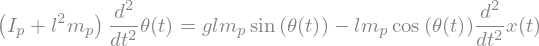

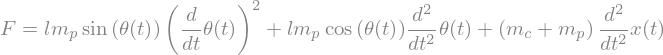

In [3]:
# nonlinear equations
nonlinear_eq1 = sympy.Eq((inertia_pole + mass_pole * length **2 ) * theta(t).diff(t,2), length * mass_pole * gravity * sympy.sin(theta(t)) - length * mass_pole * sympy.cos(theta(t)) * x(t).diff(t,2))
nonlinear_eq2 = sympy.Eq(force, (mass_cart + mass_pole)* x(t).diff(t,2) + mass_pole * length * theta(t).diff(t,2) * sympy.cos(theta(t)) + mass_pole * length * (theta(t).diff(t) ** 2) * sympy.sin(theta(t)))

display(nonlinear_eq1)
display(nonlinear_eq2)             

We can use `sympy` to rearrange the equations into the standard $\dot{x} = f(x, t, u)$ form for our nonlinear system.

Additionally, we can use `lambdify` and `subs` to create a function to calculate $\dot{x}$ for us and substitute in all the model parameters.

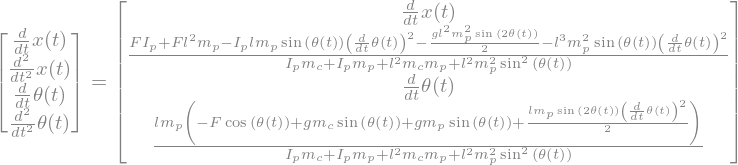

In [4]:
nonlinear_sys = sympy.solve([nonlinear_eq1, nonlinear_eq2], [x(t).diff(t, 2), theta(t).diff(t, 2)])
f_x = sympy.zeros(4,1)

f_x[0] = x(t).diff(t)
f_x[1] = nonlinear_sys[x(t).diff(t,2)]
f_x[2] = theta(t).diff(t)
f_x[3] = nonlinear_sys[theta(t).diff(t,2)]

get_nonlinear_derivative = sympy.lambdify([t, state, force], f_x.subs(params))

nonlinear_dynamics = sympy.Eq(state.diff(t), f_x)

display(sympy.simplify(nonlinear_dynamics))

## Linearization

While the nonlinear model is useful, we are going to linearize the model and apply model proedictive control and LQR. We can linearize by assuming $\theta$ is very small and taking small angle approximation. So we make the following assumptions.

\begin{equation} sin(\theta) \approx \theta \end{equation}

\begin{equation} cos(\theta) \approx 1 \end{equation}

\begin{equation} \dot{\theta}^2 \approx 0 \end{equation}

After these substitutions, the equations look like the following.

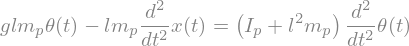

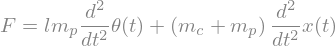

In [5]:
eq1 = sympy.Eq(length * mass_pole * gravity * theta(t) - length* mass_pole * x(t).diff(t,2), (inertia_pole + mass_pole * length **2 ) * theta(t).diff(t,2))
eq2 = sympy.Eq(force, (mass_cart + mass_pole)* x(t).diff(t,2) + mass_pole * length * theta(t).diff(t,2))

display(eq1)
display(eq2)  

## Using Sympy to Calculate State Space Matricies

Now we can use the `solve` function to isolate the variables of interest, which in our case is $\ddot{x}$ and $\ddot{\theta}$. This returns a dictionary with the keys being the variables of interest and the values being the rest of the expresssion. `sympy` takes care of a lot of algebra for us!

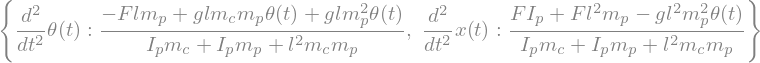

In [6]:
linearized_sys = sympy.solve([eq1, eq2], [x(t).diff(t, 2), theta(t).diff(t, 2)])

display(linearized_sys)

Then we can use the `collect` function to reorganize the expressions so that they are factored or grouped by terms of interest. In our case, the terms that we want to group by are $x$, $\dot{x}$, $\theta$, and $\dot{\theta}$. 

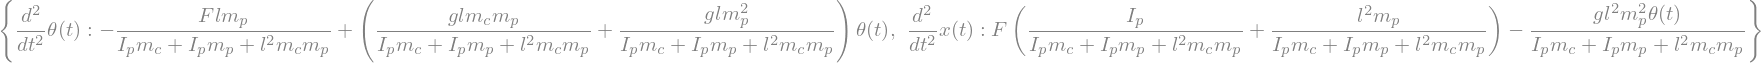

In [7]:
# The collect function reorganizes the equations so that we have the coefficient of the variables of interest
linearized_sys[x(t).diff(t,2)] = sympy.expand(linearized_sys[x(t).diff(t, 2)]).collect([x(t),x(t).diff(t), theta(t), theta(t).diff(t), force])
linearized_sys[theta(t).diff(t,2)] = sympy.expand(linearized_sys[theta(t).diff(t, 2)]).collect([x(t), x(t).diff(t) , theta(t), theta(t).diff(t), force])

display(linearized_sys)

Using `linear_eq_to_matrix` helps to get the expressions into a matrix form. The elements of the first matrix in the tuple will help give us the coefficients for our A and B matricies, specifically for the parts related to calculation of $\ddot{x}$ and $\ddot{\theta}$

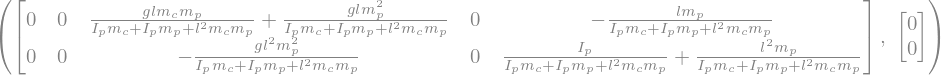

In [8]:
state_space_matricies = sympy.linear_eq_to_matrix(list(linearized_sys.values()), [x(t), x(t).diff(t) , theta(t), theta(t).diff(t), force])

display(state_space_matricies)

In [9]:
A_expression = sympy.zeros(4,4)
B_expression = sympy.zeros(4,1)

A_expression[0, 1] = 1 # Account for x dot
A_expression[2, 3] = 1 # Account for theta dot


A_expression[1, :] = state_space_matricies[0][1,:4]
A_expression[3, :] = state_space_matricies[0][0,:4]

b1 = state_space_matricies[0][1, 4]
b3 = state_space_matricies[0][0, 4]

B_expression[1] = b1
B_expression[3] = b3

## State Space Equations
Now we have the symbolic matricies for the state space equations.

Note that I'm having trouble controlling the order in which the matrices are being printed out. Normally, one would see the state space in the standard $\dot{x} = A x + Bu $ form, with $Ax$ coming before the $Bu$. Maybe this is something I improve on later.

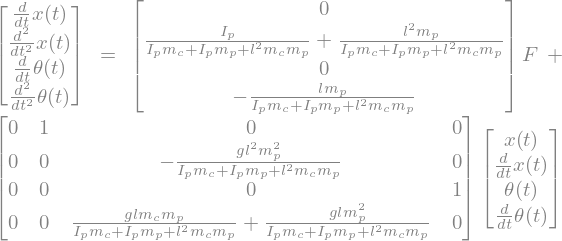

In [10]:
state_space = UnevaluatedExpr(A_expression) * UnevaluatedExpr(state) + UnevaluatedExpr(B_expression) * UnevaluatedExpr(force)

display(sympy.Eq(state.diff(t), state_space, evaluate=False))
        

Now we can evaluate the state matrices for any set of pole length, mass and inertia using `subs` in `sympy`. We can also use `lambdify` to create a function out of it.

In [11]:
A_evaluated_expression = A_expression.subs(params)
B_evaluated_expression = B_expression.subs(params)

A = np.array(A_evaluated_expression).astype(np.float64)
B = np.array(B_evaluated_expression).astype(np.float64)

get_linearized_plant_derivative = sympy.lambdify([t, state, force],state_space.subs(params).doit())

## Problem formulation

Now that the model is created, we can start thinking about a controller and its problem formulation. For this problem, I'm curious to explore model predictive control.

Overall the optimization problem will look like the following. 

$\min \sum_{n=1}^{N} x^T Q x + u^T R u $

subject to

$x_{k+1} = A_d x + B_d u$

$x_{min} \leq x \leq x_{max}$

$u_{min} \leq u \leq u_{max}$

$x_0 = x_{initial}$

In this case, I only care that the $\theta$ angle tracks 0 and the pole is balanced so my corresponding value in $Q$ reflects that. I have a small weight $R$ on control effort. I set a prediction horizon of 10 steps. 

Also, note that here I discretize using Euler discretization.

In [12]:
# Discretize
timestep = 0.01
Ad = np.identity(4) + timestep * A
Bd = timestep * B

# Constraints
u0 = 0
umin = np.array([-100]) - u0
umax = np.array([100]) - u0
xmin = np.array([-10, -100,-np.pi/2,-np.pi])
xmax = np.array([10, 100, np.pi/2, np.pi])

# Objective function
Q = sparse.diags([0., 0.0, 10., 0.])
QN = Q
R = 0.001*sparse.eye(1)

# Initial and reference states
x0 = np.array([0.,0., np.pi/10.,0.])
xr = np.array([0.,0.,0.,0.])

# Prediction horizon
N = 10

nu = 1
nx = 4

## Solving with CvxPy using Various Solvers

Below I set up the problem with `cxypy`, defining the constraints, cost function and parameters.

In [13]:
# Define problem
u = cvx.Variable((nu, N))
x = cvx.Variable((nx, N+1))
x_init = cvx.Parameter(nx)
objective = 0
constraints = [x[:,0] == x_init]
for k in range(N):
    objective += cvx.quad_form(x[:,k] - xr, Q) + cvx.quad_form(u[:,k], R)
    constraints += [x[:,k+1] == Ad@x[:,k] + Bd@u[:,k]]
    constraints += [xmin <= x[:,k], x[:,k] <= xmax]
    constraints += [umin <= u[:,k], u[:,k] <= umax]
objective += cvx.quad_form(x[:,N] - xr, QN)
prob = cvx.Problem(cvx.Minimize(objective), constraints)

nsim = 100

Below I created two wrapper functions to reshape the state derivative. This is solely because solve_ivp needs it to be a 1 D array.

In [14]:
from scipy.integrate import solve_ivp

# need to do this for ivp - needs to be a 1 d array
def get_linearized_plant_derivative_reshape(t, state, control_input):
    derivative = get_linearized_plant_derivative(t, state, control_input)
    return derivative.reshape(4,)

def get_nonlinear_plant_derivative_reshape(t, state, control_input):
    derivative = get_nonlinear_derivative(t, state, control_input)
    return derivative.reshape(4,)

I also created a function to run the solver in the loop with the plant model, allowing the caller to choose whether to simulate with the nonlinear or linear model. Since I will be running this logic a few times with multiple solvers, I figured I would make a function for it.

In [15]:
def run_cvx_solver(cvx_problem, solver_type, initial_state, nsim, linear):

    x_display = np.zeros((nsim,4))
    u_display = np.zeros(nsim)
    plant_state = initial_state
    
    for i in range(nsim): 

        # Run the MPC controller and get the first input
        # TODO handle the case when the solver fails
        x_init.value = plant_state
        cvx_problem.solve(solver=solver_type, warm_start=True)
        control_input = u[0,0].value
        
        # Integrate the plant model, Simulate given the current state and input forward by one timestep. RK4 by default
        if linear:
            result = solve_ivp(get_linearized_plant_derivative_reshape, [0, timestep], plant_state, vectorized=True, args=(control_input,))
        else:
            result = solve_ivp(get_nonlinear_plant_derivative_reshape, [0, timestep], plant_state, vectorized=True, args=(control_input,))
        plant_state = result.y[:,-1]
        
        # Collect all the values for plotting
        x_display[i, :] = plant_state
        u_display[i] = u[0,0].value
    
    return np.linspace(0, nsim*timestep, nsim), x_display, u_display
    

Here we run the solver with various solvers, including OSQP, Clarabel and SCS.

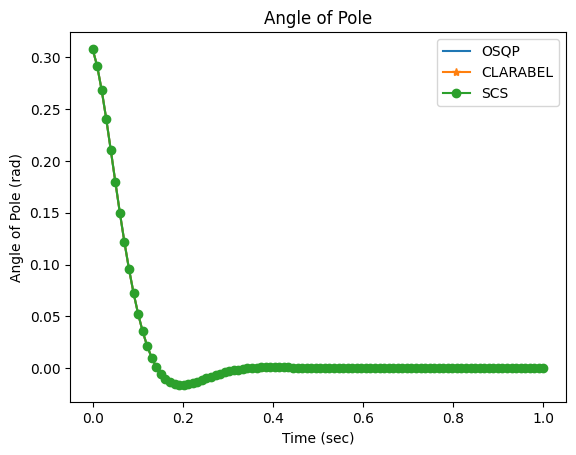

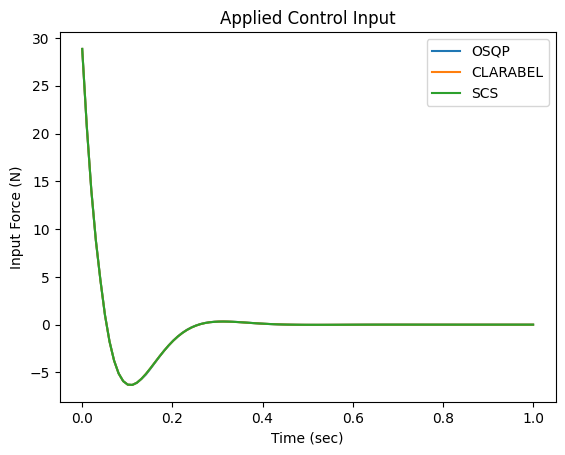

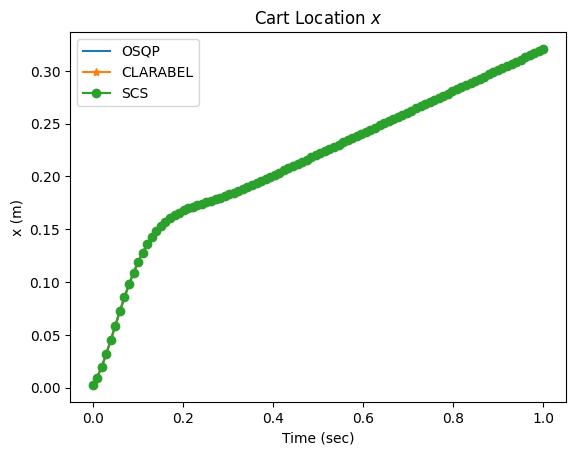

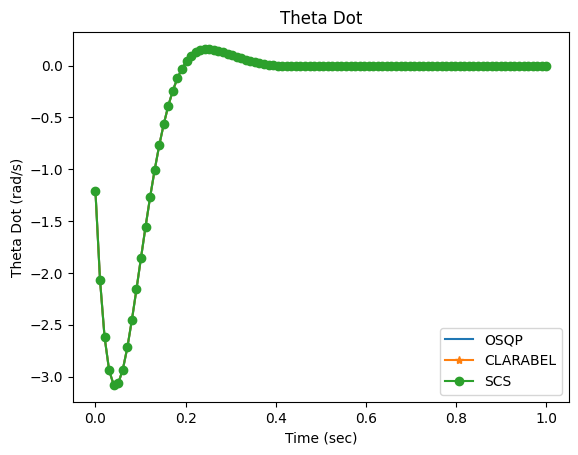

In [16]:
initial_state = np.array([0.,0., np.pi/10.,0.])

t_osqp, osqp_state, osqp_u = run_cvx_solver(prob, cvx.OSQP, initial_state, nsim, linear=True)

t_clarabel, clarabel_state, clarabel_u = run_cvx_solver(prob, cvx.CLARABEL, initial_state, nsim, linear=True)

t_scs, scs_state, scs_u = run_cvx_solver(prob, cvx.SCS, initial_state, nsim, linear=True)

plt.figure(1)
plt.plot(t_osqp, osqp_state[:, 2], label='OSQP')
plt.plot(t_clarabel, clarabel_state[:, 2], label='CLARABEL', marker='*')
plt.plot(t_scs, scs_state[:, 2], label='SCS', marker='o')
plt.ylabel('Angle of Pole (rad)')
plt.title('Angle of Pole')
plt.xlabel('Time (sec)')
plt.legend()

plt.figure(2)
plt.plot(t_osqp, osqp_u, label='OSQP')
plt.plot(t_clarabel, clarabel_u, label='CLARABEL')
plt.plot(t_scs, scs_u, label='SCS')
plt.title('Applied Control Input')
plt.ylabel('Input Force (N)')
plt.xlabel('Time (sec)')
plt.legend()

plt.figure(3)
plt.plot(t_osqp, osqp_state[:, 0], label='OSQP')
plt.plot(t_clarabel, clarabel_state[:, 0], label='CLARABEL', marker='*')
plt.plot(t_scs, scs_state[:, 0], label='SCS', marker='o')
plt.ylabel('x (m)')
plt.title('Cart Location $x$')
plt.xlabel('Time (sec)')
plt.legend()

plt.figure(4)
plt.plot(t_osqp, osqp_state[:,3], label='OSQP')
plt.plot(t_clarabel, clarabel_state[:, 3], label='CLARABEL', marker='*')
plt.plot(t_scs, scs_state[:, 3], label='SCS', marker='o')
plt.ylabel('Theta Dot (rad/s)')
plt.title('Theta Dot')
plt.xlabel('Time (sec)')
plt.legend()

We can see that all the solvers produce pretty much the same result. This is what I would expect given the way we formulated this as a simple QP problem.

The MPC is able to bring the angle of the pole close to 0 and balance it. However, in the plot of cart location, we see that the cart is still moving forward. While this is acceptable in some scenarios if your system has unlimited room, we may want the cart pole system to balance within a more confined space. Perhaps I can further tune the MPC by modifying the weights or constraints on $x$. 

In this next step, we can try to simulate using a plant model that has the nonlinearities.

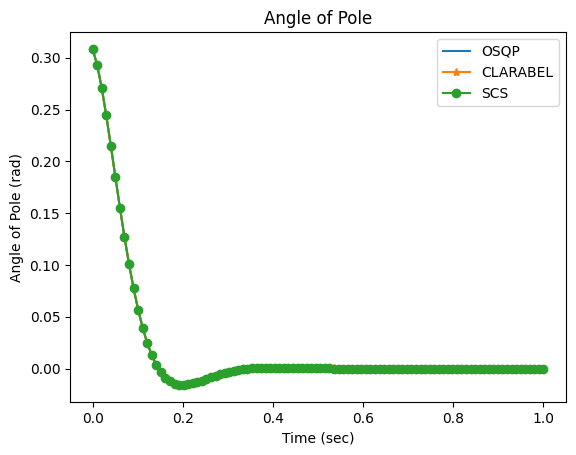

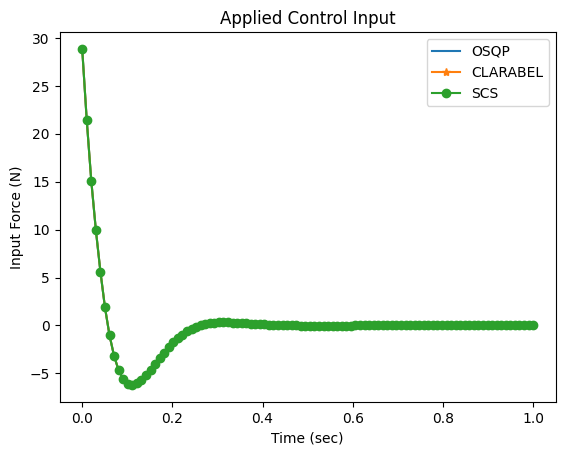

In [17]:
t_osqp, osqp_state, osqp_u = run_cvx_solver(prob, cvx.OSQP, initial_state, nsim, linear=False)

t_clarabel, clarabel_state, clarabel_u = run_cvx_solver(prob, cvx.CLARABEL, initial_state, nsim, linear=False)

t_scs, scs_state, scs_u = run_cvx_solver(prob, cvx.SCS, initial_state, nsim, linear=False)

plt.figure(1)
plt.plot(t_osqp, osqp_state[:, 2], label='OSQP')
plt.plot(t_clarabel, clarabel_state[:, 2], label='CLARABEL', marker='*')
plt.plot(t_scs, scs_state[:, 2], label='SCS', marker='o')
plt.ylabel('Angle of Pole (rad)')
plt.title('Angle of Pole')
plt.xlabel('Time (sec)')
plt.legend()

plt.figure(2)
plt.plot(t_osqp, osqp_u, label='OSQP')
plt.plot(t_clarabel, clarabel_u, label='CLARABEL', marker='*')
plt.plot(t_scs, scs_u, label='SCS', marker='o')
plt.title('Applied Control Input')
plt.ylabel('Input Force (N)')
plt.xlabel('Time (sec)')
plt.legend()

Simulation with a nonlinear plant seems to give similar results as the previous run. Perhaps if I gave an initial condition with a larger $\theta$, I might see more of a different response.

## Comparison of MPC to LQR

While playing around with MPC can be a lot of fun, it's good to compare performance to a baseline algorithm or some simpler algorithm. Often times, I see algorithms compared to PID because if you could just use PID, why do you need a fancy algorithm? In this case, we will compare against an infinite horizon LQR. 

We use Python `control` library to create a state space system from our state space matrices from earlier. Then we discretize and find the optimal $K$ gain matrix.

Note that I did tune the LQR a little differently, putting a small weight on $x$, $\dot{x}$ and $\dot{\theta}$.

In [18]:
import control
import control.matlab

# Create Continous System and Convert to Discrete
C = np.array([0, 0, 1, 0])
D = 0
continuous_sys = control.StateSpace(A, B, C, D)
discrete_sys = control.matlab.c2d(continuous_sys, timestep)

# Calculate gains
Q = np.diag([1, 3, 10, 1])
R = 0.1
K, S, E = control.dlqr(discrete_sys, Q, R)

Then we simulate and compare against the MPC results.

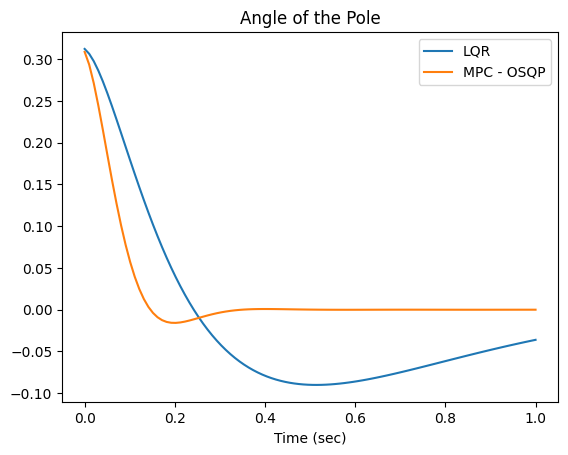

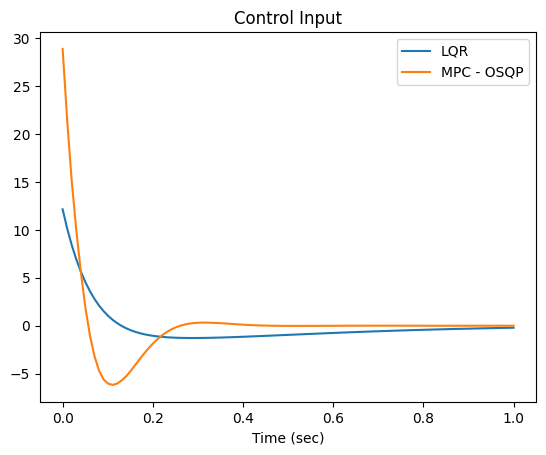

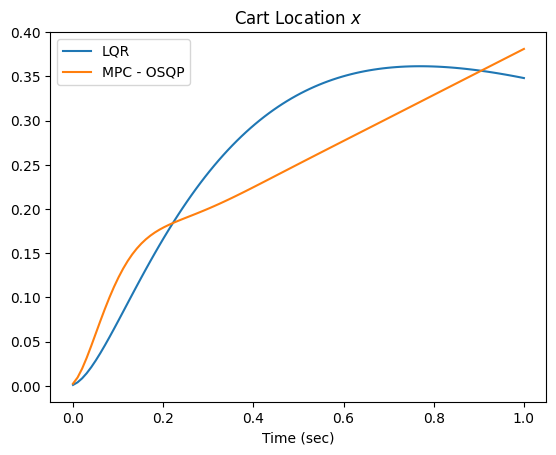

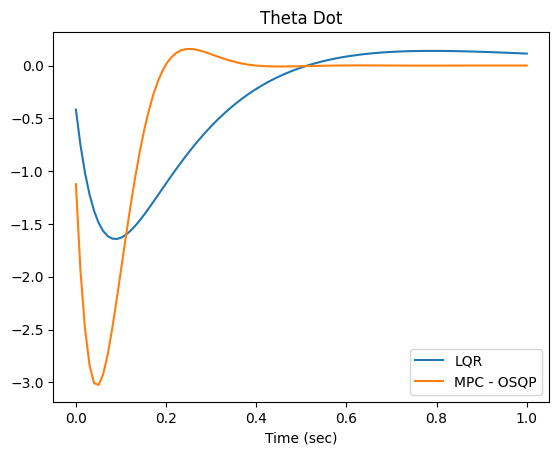

In [19]:
x_display = np.zeros((nsim,4))
u_display = np.zeros(nsim)
plant_state = initial_state

for i in range(nsim): 

    # control input is a 1 x 1 numpy array so we need to get out the value
    control_input = -(K @ plant_state.reshape(4,1))[0,0]
    
    # Integrate the plant model, Simulate given the current state and input forward by one timestep. RK4 by default
    result = solve_ivp(get_nonlinear_plant_derivative_reshape, [0, timestep], plant_state, vectorized=True, args=(control_input,))
    plant_state = result.y[:,-1]
    
    # Collect all the values for plotting
    x_display[i, :] = plant_state
    u_display[i] = control_input

plt.figure(1)
time = np.linspace(0, nsim*timestep, nsim)
plt.plot(time, x_display[:, 2], label='LQR')
plt.plot(t_osqp, osqp_state[:, 2], label='MPC - OSQP')
plt.title('Angle of the Pole')
plt.xlabel('Time (sec)')
plt.legend()

plt.figure(2)
plt.plot(time, u_display, label='LQR')
plt.plot(t_osqp, osqp_u, label='MPC - OSQP')
plt.title('Control Input')
plt.xlabel('Time (sec)')
plt.legend()

plt.figure(3)
plt.plot(time, x_display[:, 0], label='LQR')
plt.plot(t_osqp, osqp_state[:, 0], label='MPC - OSQP')
plt.title('Cart Location $x$')
plt.xlabel('Time (sec)')
plt.legend()

plt.figure(4)
plt.plot(time, x_display[:, 3], label='LQR')
plt.plot(t_osqp, osqp_state[:, 3], label='MPC - OSQP')
plt.title('Theta Dot')
plt.xlabel('Time (sec)')
plt.legend()


The LQR does an acceptable job but with the given tuning and this specific initial state, the MPC has better performance. The MPC is able to get the angle of the pole closer to 0 and faster than the LQR. The LQR also overshoots the angle of the pole a bit more than the MPC. 

Perhaps for a future notebook, I could keep tweaking and playing around with the tunings of both algorithms and evaluate performance across a wider range of initial conditions.

## Sources

1. [OSQP Documentation Examples](https://osqp.org/docs/examples/mpc.html)
2. [Inverted Pendulum: System Modeling](https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling)